# *Name* : *GANESH* *BAJAJ*
# *TASK* : *FACE_MASK_DETECTOR*

In [ ]:
import os
from imutils import paths
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input,Flatten,AveragePooling2D,Dense,Dropout
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
#loading and preprocessing our dataset
path='/content/drive/MyDrive/dataset'
imagepaths = list(paths.list_images(path))
data =[]
labels = []
for imagepath in imagepaths:
  label = imagepath.split(os.path.sep)[-2]
  image = load_img(imagepath,target_size= (224,224))
  image= img_to_array(image)
  image= preprocess_input(image)

  data.append(image)
  labels.append(label)
  
data = np.array(data,dtype='float32')
labels = np.array(labels)  

In [ ]:
#processing the dataset
lb = LabelBinarizer()
labels= lb.fit_transform(labels)
labels = to_categorical(labels)

(trainx,testx,trainy,testy)= train_test_split(data,labels,test_size=0.2,stratify = labels)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [ ]:
#loading the MobileNetv2 model and ensuring that include_top=False
basemodel = MobileNetV2(weights = 'imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(7,7))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(128,activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(2,activation='softmax')(headmodel)

model = Model(inputs=basemodel.input,outputs = headmodel)

#freezing the layers of basemodel
for layer in basemodel.layers:
  layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#training the model
opt = Adam(lr=1e-4,decay=1e-4/20)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

hist=model.fit(aug.flow(x=trainx,y=trainy,batch_size=32),epochs=20,steps_per_epoch=len(trainx)//32,
          validation_data=(testx,testy),validation_steps=len(testy)//32)



Epoch 1/20
34/34 [==============================] - 61s 2s/step - loss: 0.6292 - accuracy: 0.6872 - val_loss: 0.2269 - val_accuracy: 0.9855
Epoch 2/20
34/34 [==============================] - 57s 2s/step - loss: 0.2616 - accuracy: 0.9461 - val_loss: 0.1030 - val_accuracy: 1.0000
Epoch 3/20
34/34 [==============================] - 56s 2s/step - loss: 0.1355 - accuracy: 0.9832 - val_loss: 0.0595 - val_accuracy: 1.0000
Epoch 4/20
34/34 [==============================] - 57s 2s/step - loss: 0.0839 - accuracy: 0.9885 - val_loss: 0.0399 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 56s 2s/step - loss: 0.0604 - accuracy: 0.9924 - val_loss: 0.0298 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 57s 2s/step - loss: 0.0669 - accuracy: 0.9873 - val_loss: 0.0243 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 56s 2s/step - loss: 0.0371 - accuracy: 0.9951 - val_loss: 0.0211 - val_accuracy: 0.9964
Epoch 8/20
34/34 [==

In [ ]:
#predicting on test data
predictions = model.predict(testx,batch_size=32)
preidx = np.argmax(predictions,axis=1)

print(classification_report(testy.argmax(axis=1),preidx,target_names=lb.classes_))

model.save('mask_detector.model',save_format="h5")


              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [ ]:
model.save('/content/drive/MyDrive/my_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_model/assets


In [ ]:
from tensorflow.keras.models import load_model
mod = load_model('/content/drive/MyDrive/my_model')

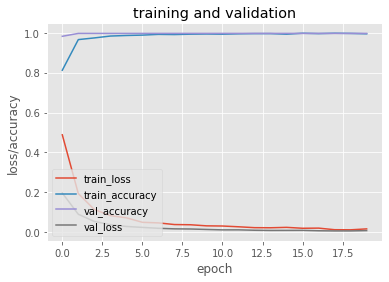

In [ ]:
#plotting the training loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,20),hist.history['loss'],label='train_loss')
plt.plot(np.arange(0,20),hist.history['accuracy'],label='train_accuracy')
plt.plot(np.arange(0,20),hist.history['val_accuracy'],label='val_accuracy')
plt.plot(np.arange(0,20),hist.history['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.title('training and validation')
plt.legend(loc='lower left')
plt.savefig('plot.png')



In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
import matplotlib.pyplot as plt


'''
ap = argparse.ArgumentParser()
ap.add_argument('-i','--image',help='path to image',required=True)
ap.add_argument("-f", "--face", type=str,default="face_detector",help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())
'''
#loading the models
prototxtpath = '/content/drive/MyDrive/face_detector/deploy.prototxt'
weightspath = '/content/drive/MyDrive/face_detector/res10_300x300_ssd_iter_140000.caffemodel'

net = cv2.dnn.readNet(weightspath,prototxtpath)
model = load_model('/content/drive/MyDrive/mask_detector.model')



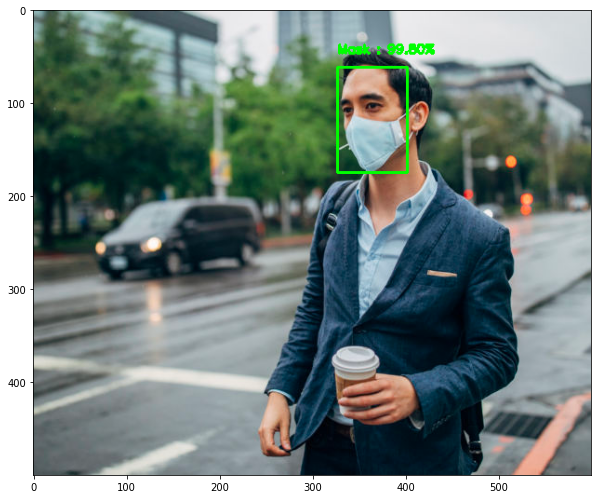

In [ ]:
#passing the image through model to get face detections
img = cv2.imread('/content/drive/MyDrive/examples/example_01.png')
ori = img.copy()
(h,w) = img.shape[:2]
blob = cv2.dnn.blobFromImage(img,1,(300,300),100)

net.setInput(blob)
detections = net.forward()
confidence = 0.5
for i in range(0,detections.shape[2]):
  if detections[0,0,i,2]>=confidence:
    box=detections[0,0,i,3:7]*np.array([w,h,w,h])
    (startx,starty,endx,endy) = box.astype('int')
    (startx,starty) = (max(0,startx),max(0,starty))
    (endx,endy) = (min(endx,w-1),min(endy,h-1))
    face = img[starty:endy,startx:endx]
    face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
    face = cv2.resize(face,(224,224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face,axis=0)

    (mask,without_mask)= model.predict(face)[0]
    label = 'Mask' if mask >without_mask else 'No_mask'
    color = (0,255,0) if label =='Mask' else (255,0,0)
    label = "{} : {:.2f}% ".format(label,detections[0,0,i,2]*100)
    cv2.putText(img,label,(startx,starty-15),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
    cv2.rectangle(img,(startx,starty),(endx,endy),color,2)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img)

In [27]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import matplotlib.pyplot as plt


def detect_and_predict_mask(frame,net,model):
  (h,w) = frame.shape[:2]
  blob = cv2.dnn.blobFromImage(frame,1,(300,300),(104.0, 177.0, 123.0))
  net.setInput(blob)
  detections = net.forward()

  faces=[]
  locs = []
  preds = []
  
  for i in range(0,detections.shape[2]):
    confi = 0.5
    if detections[0,0,i,2]>=confi:
      box=detections[0,0,i,3:7]*np.array([w,h,w,h])
      (startx, starty, endx, endy) = box.astype("int")
      (startx,starty) = (max(0,startx),max(0,starty))
      (endx,endy) = (min(endx,w-1),min(endy,h-1))
      face = frame[starty:endy,startx:endx]
      face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
      face = cv2.resize(face,(224,224))
      face = img_to_array(face)
      face = preprocess_input(face)

      faces.append(face)
      locs.append((startx, starty, endx, endy))

  if len(faces)>0:

    faces=np.array(faces,dtype='float32')
    preds = model.predict(faces,batch_size=32)

  return (locs,preds)

#loading the models
prototxtpath = '/content/drive/MyDrive/face_detector/deploy.prototxt'
weightspath = '/content/drive/MyDrive/face_detector/res10_300x300_ssd_iter_140000.caffemodel'

net = cv2.dnn.readNet(weightspath,prototxtpath)
model = load_model('/content/drive/MyDrive/mask_detector.model')







In [31]:
#vs = VideoStream(src=0).start()
vs = cv2.VideoCapture('/content/drive/MyDrive/AwesomeScreensho(1).mp4')
#time.sleep(2)

video = None
while True:
  _,frame = vs.read()
  #frame = cv2.imread(frame)
  frame = imutils.resize(frame,width=400)
  (locs,preds) = detect_and_predict_mask(frame,net,model)
  for (box,pred) in zip(locs,preds):
    (startx,starty,endx,endy)=box
    label='Mask' if pred[0]>pred[1] else 'without mask'
    color = (0,255,0) if label == 'Mask' else (0,0,255)
    label = "{}: {:.2f}%".format(label, max(pred[0],pred[1]) * 100)

    cv2.putText(frame,label,(startx,starty-15),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
    cv2.putText(frame,'Face_Mash_Detector',(15,15),cv2.FONT_HERSHEY_COMPLEX,0.45,(0,122,255),1)
    cv2.putText(frame,'By Ganesh Bajaj',(15,30),cv2.FONT_HERSHEY_COMPLEX,0.45,(0,122,255),1)
    cv2.rectangle(frame,(startx,starty),(endx,endy),color,2)
  #plt.figure(figsize=(10,10))
  #plt.imshow(frame)
  if video is None:
    fourcc = cv2.VideoWriter_fourcc(*'MPEG')
    video = cv2.VideoWriter('/content/my_video.avi',fourcc,20,(frame.shape[1],frame.shape[0]),True)
  else:
    video.write(frame)  
  key = cv2.waitKey(1) & 0xFF

  if key==ord('q'):
    break  
#vs.stop()

AttributeError: ignored

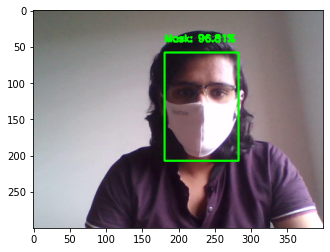

In [ ]:
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)

In [32]:
!ffmpeg -i '/content/my_video.avi' '/content/output.mp4'
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
y
